# **Processing sleeping data**

**1. Combine LFP data from sleeping recordings to the spatial data to account for movement ✔️**


In [1]:
import sys  
sys.path.insert(0, 'D:/Beths/')
import os
import re
import pandas as pd
import numpy as np
import yasa
import mne
from mne.filter import filter_data, resample
import matplotlib.pyplot as plt
from scipy import signal

## Import from my files
from data_lfp import mne_lfp_Axona, load_lfp_Axona
from data_pos import RecPos

### Sleeping recordings


In [2]:
df = pd.read_csv('data_scheme.csv', parse_dates=['date_time'])
cols = df.columns
df[cols[2:]].loc[df[cols[2:]].sleep == 1]

,duration,rat,n_channels,sleep,maze,habituation,treatment,light,date_time
70,120.0,CanCCaRet2,32,1,small_sq,0,muscimol,NaN,2019-03-08 16:40:00
71,120.0,CanCCaRet2,32,1,small_sq,0,muscimol,NaN,2019-03-08 17:03:04
72,120.0,CanCCaRet2,32,1,small_sq,0,muscimol,NaN,2019-03-08 17:25:01
73,120.0,CanCCaRet2,32,1,small_sq,0,muscimol,NaN,2019-03-08 17:47:00
89,120.0,CanCCaRet2,32,1,small_sq,0,muscimol,NaN,2019-03-08 15:52:00
...,...,...,...,...,...,...,...,...,...
2577,120.0,LSR5,32,1,sleep,0,lesion,NaN,2017-12-05 16:45:05
2578,120.0,LSR5,32,1,sleep,0,lesion,NaN,2017-12-05 17:15:04
2579,120.0,LSR5,32,1,sleep,0,lesion,NaN,2017-12-08 17:37:05
2580,902.0,LSR5,32,1,sleep,0,lesion,NaN,2017-12-08 14:27:00


In [3]:
#Number of sleeping records per rat
print(df.loc[df.sleep == 1, ['rat', 'sleep']].groupby('rat').sum())
#Selecting sleep files
df = pd.read_csv('data_scheme.csv', parse_dates=['date_time'])
sleep_files = df.loc[df.sleep == 1, ['folder', 'filename']].agg('/'.join, axis=1).values
print(f'\nNumber of rats with sleeping records: {len(set(df.loc[df.sleep == 1].rat))}')
print(f'Number of sleeping files {len(sleep_files)}')

             sleep
rat               
CRS1             4
CRS2             3
CSR4             5
CSR5             7
CSR6             6
CanCCaRet2       6
CanCSR7          2
CanCSR8          8
CanCSRetCa2      4
CanCSubCa1       3
LRS1             4
LSR4            10
LSR5             6
LSR7             4

Number of rats with sleeping records: 14
Number of sleeping files 72


### **Idea: Use movement as an indicator of awakeness**
#### Open LFP and Spatial information and mark movement as MNE envents)

In [4]:
def detect_movement(x, y, delta=1):
    
    '''function that detects when the animal moved
    
    Inputs:
    x,y (float array): 
        Spatial coordinates x,y
    delta(float):
        An acceptable error 
    
    Output:
        moving (array):
        1 for movement, 0 for no movement
    '''
    def calc_dist(x0, x1, y0, y1): #(distance in pixels)
        return ((x1-x0)**2 + (y1-y0)**2)**.5
    
    moving = np.zeros(len(x)*5)
    for i in range(0, len(x)-1):
        if calc_dist(x[i], x[i+1], y[i], y[i+1]) > delta:
            moving[5*i:5*i+5] = 1 ## increase sample rate to be the same as the recording
    return np.asarray(moving)


def create_events(record, events):
    '''Create events on MNE object
    Inputs:
        record(mne_object): recording to add events
        events_time(2D np array): array 0,1 with same lenght of recording dimension (1, lengt(record))
        
    output: 
    record(mne_object): Record with events added
        
    '''
    try:
        assert len(record.times) == events.shape[1]
        stim_data = events
        info = mne.create_info(['STI'], record1.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(stim_data, info)
        record.add_channels([stim_raw], force_update_info=True)
    except AssertionError as error:
        print(error)
        print('The lenght of events needs to be equal to record lenght.')
    return record

# Axona reading pixels:
#  no. pixels in big light = 18.35 +/- 8.48
#  no. pixels in small light = 10.96 +/- 5.92

#### **Open spatial data**

(Spatial data is sampled at 50 Hz, so every 5 LFPs I have one Spatial info)
1. Compare lenghts
2. Syncronize
3. detect movement

Most sleep detection papers use EMG/LFP.

**Detection of slow-wave sleep, sharp-wave ripples** [https://www.cell.com/current-biology/pdfExtended/S0960-9822(19)30006-5]


Mean running speed for each1.6 s bin was also estimated. In the absence of EMG recordings, we could not unequivocally discriminate between slow wavesleep and quiet immmobility, we therefore restricted all analyses to epochs termed ‘rest’. Rest was defined as epochs with runningspeed < 2.5cm/s, and theta/delta power ratio < 2 and waking movement as theta/delta power ratio > 2 and speed > 2.5cm/s. Sharp-wave ripples were detected by first filtering the LFP in the band 100-250Hz. The instantaneous power of the filtered LFP was thenestimated by calculating the root mean square over 7ms intervals (MATLAB function ‘envelope’ with option ‘rms’). From all LFPsacross tetrodes in the CA1 layer, the LFP whose power estimate had the highest standard deviation was then used to define rippleevents, as 100ms windows around the peak power, whenever the power was greater than the 99thpercentile of all powers in the trial(approximately equal to 4 standard deviations above the mean). Multi-unit activity (MUA) bursts were defined by binning all spikesfrom CS cells into 1ms bins and smoothing the resulting binned spike train with a Gaussian kernel (s.d. 10ms). MUA events werethen defined as crossing of a threshold defined as 3 standard deviations above the mean of the smoothed spike train, with a durationfrom 100-750ms. 
Only MUA bursts which temporally overlapped (even in part) with SWR events were included in the replay analysis.

**Spindle detection** [https://www.jneurosci.org/content/jneuro/26/50/12914.full.pdf]

Power spectra of delta(0–4 Hz), theta (5–10 Hz), and spindle (12–15 Hz) frequency bandswere calculated continuously, and sleep–wake episodes were scored byvisual assessment for 10 s epochs according to the standard criteria (Bjor-vatn et al., 1998). Briefly, the awake state was marked by the presence oflow-amplitude fast activity associated with EMG tonus; SWS was identi-fied by continuous high-amplitude slow activity, regular appearance ofspindles, and decreased EMG activity. Transitions from SWS into REMsleep were identified by a decrease in high-amplitude slow activity, in-crease of theta activity, and presence of spindles. REM sleep was charac-terized by dominant theta activity, low-voltage fast activity, and an ab-sence of EMG tonus. Behavioral states were additionally verified by videorecording.

In [5]:
# file = sleep_files[6]

# pos1 = RecPos(file)
# xr,yr = pos1.get_raw_pos()
# x,y = pos1.get_position()
# # pos1.get_angular_pos()
# # pos1.get_speed()

In [6]:
def plot_maze(x,y):
    ax = plt.figure(figsize=(6,6))
#     ax = plt.plot(x,y, c= 'b', linewidth=3)
    ax = plt.scatter(x,y, c= 'r', marker='.')
    ax = plt.xlim(150, 300)
    ax = plt.ylim(250, 400)
    ax = plt.xlabel('X pixels')
    ax = plt.ylabel('Y pixels')
    plt.tight_layout()
    return plt.show()

# plot_maze(x,y)

In [7]:
sleep_files[0]
pos1 = RecPos(file)
x,y = pos1.get_position()
moving = detect_movement(x, y, .7)
nx = [n*m for n, m in zip(x, moving)]
ny = [n*m for n, m in zip(y, moving)]

NameError: name 'file' is not defined

In [ ]:
plot_maze(nx, ny)

In [ ]:
for file in sleep_files[10:15]:
    print(file)
    pos1 = RecPos(file)
    x,y = pos1.get_position()
    moving = detect_movement(x, y, 3)
    ax = plt.figure(figsize=(4,4))
    ax = plt.plot(x,y, c= 'b', linewidth=1)
    ax = plt.xlabel('X pixels')
    ax = plt.ylabel('Y pixels')
    plt.tight_layout()
    plt.show()

#### **Select files with sleep**

#### **Open sleep file and add movement as event Channel**

In [37]:
position = RecPos(file)
x, y = position.get_raw_pos()
moving = detect_movement(x, y, 30)
events = moving.reshape(1, len(moving))
record1 = mne_lfp_Axona(file)
record1 = create_events(record1, events) 

Creating RawArray with float64 data, n_channels=31, n_times=300000
    Range : 0 ... 299999 =      0.000 ...  1199.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=300000
    Range : 0 ... 299999 =      0.000 ...  1199.996 secs
Ready.


In [38]:
events = mne.find_events(record1, stim_channel='STI')

248 events found
Event IDs: [1]


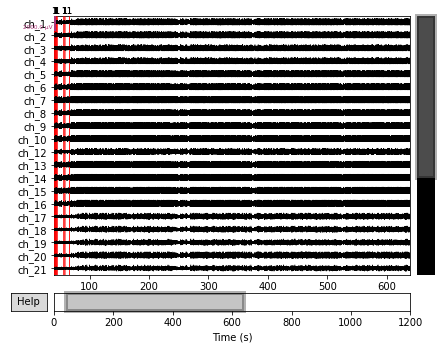

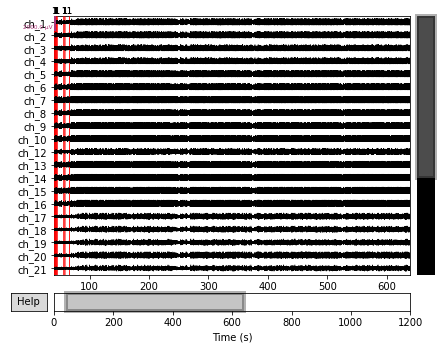

In [39]:
record1.plot(events=events, start=40, duration=600, scalings=dict(eeg=100e-5), event_color={1: 'r'})

In [56]:
record1['ch_1']

(array([[ 0.000000e+00, -3.906250e-06,  9.765625e-05, ...,  3.906250e-05,
          3.125000e-05, -1.171875e-05]]),
 array([0.000000e+00, 4.000000e-03, 8.000000e-03, ..., 1.199988e+03,
        1.199992e+03, 1.199996e+03]))

In [49]:
# Broadband (1 - 30 Hz) bandpass filter
record2 = mne_lfp_Axona(file)
info = record2.info
sf = info['sfreq']
ch = info['ch_names'][0:2]
pick = mne.pick_channels(info['ch_names'], include = info['ch_names'][0:1])
freq_broad = (1, 30)
data_broad = record2.filter(l_freq= freq_broad[0], h_freq=freq_broad[1],  method='fir',verbose=0).copy()

Creating RawArray with float64 data, n_channels=31, n_times=300000
    Range : 0 ... 299999 =      0.000 ...  1199.996 secs
Ready.


### **Filtering signal into bands**
<ul>
    <li>Delta (1-4Hz)</li>
    <li>Theta (4-12Hz)</li>
    <li>Beta (12-30Hz)</li>
</ul>


In [50]:
import seaborn as sns
sns.set(font_scale=1.2)

In [59]:
t0 = 100
tf = 130
rec = record2.filter( l_freq=1, h_freq=30)
data = rec[12][0][0][250*t0:250*tf]
sfreq = 250
print(len(data))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 sec)

7500


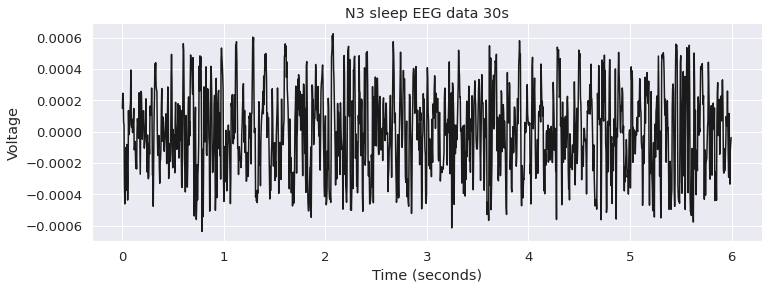

In [93]:
# Define sampling frequency and time vector
data = signal.resample(data, int(7500/5)) # resampling 
time = np.arange(len(data)) / sfreq
# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
# plt.xlim([time.min(), time.max()])
plt.title(f'N3 sleep EEG data {tf-t0}s')
sns.despine()

In [64]:
info = mne.create_info(ch_names=['RSC'],
                       ch_types=['eeg'],
                       sfreq=250)
ch1 = mne.io.RawArray(record1['ch_1'][0], info)

Creating RawArray with float64 data, n_channels=1, n_times=300000
    Range : 0 ... 299999 =      0.000 ...  1199.996 secs
Ready.


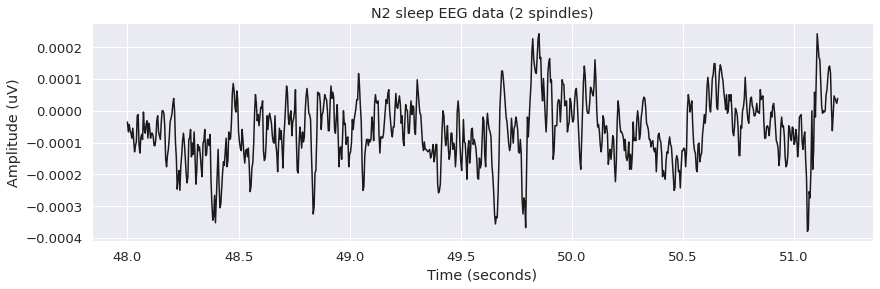

In [95]:
# ch1.plot(show_scrollbars=False, show_scalebars=True, scalings=dict(eeg=100e-5))

times = np.arange(len(ch1)) / 250.

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(times[12000:12800], record1['ch_1'][0][0][12000:12800], lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
# plt.xlim([times.min(), times.max()])
plt.title('N2 sleep EEG data (2 spindles)')
sns.despine()

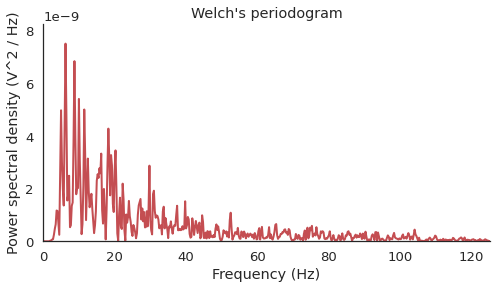

In [45]:
from scipy import signal

# Define window length (4 seconds)
win = 4 * sfreq
freqs, psd = signal.welch(data, sfreq, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='r', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()